In [ ]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint on rail mask

# Color/size filter (RGB targets; converted to BGR internally)
TARGET_COLORS_RGB = [(119,104,67), (81,42,45)]
TOLERANCE         = 20.0      # color distance (BGR) – increase if too strict
MIN_REGION_SIZE   = 30        # connected-component area in px
MIN_REGION_HEIGHT = 150       # connected-component bbox height in px

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Model (load, fuse, warmup)
# =======================
model = YOLO(weights)
try:
    model.fuse()
except Exception:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# FAST color+size filter (vectorized + ROI-cropped)
# =======================
def highlight_rails_mask_only_fast(
    img_bgr: np.ndarray,
    rail_mask: np.ndarray,
    target_colors_rgb: list[tuple[int,int,int]],
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 150
) -> np.ndarray:
    """
    Returns boolean mask of rail pixels that:
      (1) color-match any target color within tolerance, AND
      (2) lie inside rail_mask, AND
      (3) pass connected-component size/height filters.
    """
    H, W = img_bgr.shape[:2]
    filtered_full = np.zeros((H, W), dtype=bool)
    if not rail_mask.any():
        return filtered_full

    # Crop to rail ROI
    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    # Vectorized color match
    targets_bgr = np.array([(b,g,r) for r,g,b in target_colors_rgb], np.float32)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:, :, None, :] - targets_bgr[None, None, :, :]
    dist2 = np.sum(diff * diff, axis=-1)
    color_mask_roi = np.any(dist2 <= (tolerance * tolerance), axis=-1)

    combined_roi = mask_roi & color_mask_roi

    # Connected-component filter
    comp_u8 = combined_roi.astype(np.uint8)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(comp_u8, 8)

    filtered_roi = np.zeros_like(combined_roi)
    for lbl in range(1, n_labels):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filtered_roi[labels == lbl] = True

    filtered_full[y0:y1, x0:x1] = filtered_roi
    return filtered_full

# =======================
# Per-frame pipeline
# =======================
def process_frame(img_bgr: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      - out        : original + red tint on rails + neon-green on unfiltered rails
      - rail_mask  : boolean mask of all rails
    """
    res = model.predict(
        img_bgr, task="segment", imgsz=IMG_SIZE, device=device,
        conf=CONF, iou=IOU, classes=[RAIL_ID],
        max_det=20, verbose=False, half=half
    )[0]

    H, W = img_bgr.shape[:2]
    if res.masks is None:
        return img_bgr.copy(), np.zeros((H, W), bool)

    # union of rail segments
    m = res.masks.data
    union = (m.sum(dim=0) > 0).float().cpu().numpy()
    if union.shape != (H, W):
        union = cv2.resize(union, (W, H), interpolation=cv2.INTER_NEAREST)
    rail_mask = union.astype(bool)

    # compute filtered (original neon-green) mask
    filtered_mask = highlight_rails_mask_only_fast(
        img_bgr, rail_mask,
        TARGET_COLORS_RGB, TOLERANCE,
        MIN_REGION_SIZE, MIN_REGION_HEIGHT
    )

    # inverted mask = rails minus the filtered zones
    inverted_mask = rail_mask & ~filtered_mask

    # compose visualization
    out = img_bgr.copy()

    # red tint for rails
    overlay = out.copy()
    overlay[rail_mask] = (0, 0, 255)
    out = cv2.addWeighted(overlay, ALPHA, out, 1 - ALPHA, 0)

    # neon-green on the *inverse* region
    out[inverted_mask] = (0, 255, 0)

    return out, rail_mask

# =======================
# Main: run & step through
# =======================
if __name__ == "__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir, "frame_*.jpg")))
    if not paths:
        print("No frames found in", image_dir)
        sys.exit(1)

    for p in paths:
        img = cv2.imread(p)
        if img is None:
            continue

        vis, _ = process_frame(img)

        # show original | inverted neon-green
        combo = np.hstack((img, vis))
        cv2.imshow("Original (Left) | Inverted Rails (Right)", combo)

        # SPACE → next, 'q' → quit
        while True:
            key = cv2.waitKey(0) & 0xFF
            if key == 32:
                break
            elif key == ord('q'):
                cv2.destroyAllWindows()
                sys.exit(0)

        cv2.destroyAllWindows()


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-05 00:27:48.463 Python[35645:28740871] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-05 00:27:48.463 Python[35645:28740871] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [ ]:
#!/usr/bin/env python3
import os, glob, sys, time

import cv2
import torch
import numpy as np
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint on rail mask

# Color/size filter (RGB targets; converted to BGR internally)
TARGET_COLORS_RGB = [(119,104,67), (81,42,45)]
TOLERANCE         = 20.0       # color distance (BGR)
MIN_REGION_SIZE   = 30         # connected-component area in px
MIN_REGION_HEIGHT = 150        # connected-component bbox height in px

# simple HSV threshold for the barrier boards (white/red stripes)
OBSTACLE_HSV_LOW  = np.array([0,  0,200], dtype=np.uint8)
OBSTACLE_HSV_HIGH = np.array([180,50,255], dtype=np.uint8)

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Model (load, fuse, warmup)
# =======================
model = YOLO(weights)
try:
    model.fuse()
except:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# FAST color+size filter (vectorized + ROI-cropped)
# =======================
def highlight_rails_mask_only_fast(
    img_bgr: np.ndarray,
    rail_mask: np.ndarray,
    target_colors_rgb: list[tuple[int,int,int]],
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 150
) -> np.ndarray:
    H, W = img_bgr.shape[:2]
    filtered_full = np.zeros((H, W), dtype=bool)
    if not rail_mask.any():
        return filtered_full

    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1

    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    targets_bgr = np.array([(r,g,b)[::-1] for r,g,b in target_colors_rgb], np.float32)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:,:,None,:] - targets_bgr[None,None,:,:]
    dist2 = np.sum(diff*diff, axis=-1)
    color_mask = np.any(dist2 <= (tolerance*tolerance), axis=-1)

    combined = mask_roi & color_mask

    comp_u8 = combined.astype(np.uint8)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(comp_u8, 8)
    filt = np.zeros_like(combined)
    for lbl in range(1, n_labels):
        a = stats[lbl,cv2.CC_STAT_AREA]
        h = stats[lbl,cv2.CC_STAT_HEIGHT]
        if a>=min_region_size and h>=min_region_height:
            filt[labels==lbl] = True

    filtered_full[y0:y1, x0:x1] = filt
    return filtered_full

# =======================
# Per-frame pipeline
# =======================
def process_frame(img_bgr: np.ndarray):
    """
    Returns:
      - vis: original tinted with rails (red) and filtered (green)
      - rail_mask: boolean rail mask
      - filtered_mask: boolean neon-green mask
    """
    res = model.predict(
        img_bgr, task="segment", imgsz=IMG_SIZE, device=device,
        conf=CONF, iou=IOU, classes=[RAIL_ID],
        max_det=20, verbose=False, half=half
    )[0]

    H, W = img_bgr.shape[:2]
    if res.masks is None:
        return img_bgr.copy(), np.zeros((H,W),bool), np.zeros((H,W),bool)

    m = res.masks.data
    union = (m.sum(dim=0)>0).float().cpu().numpy()
    if union.shape!=(H,W):
        union = cv2.resize(union, (W,H), interpolation=cv2.INTER_NEAREST)
    rail_mask = union.astype(bool)

    filtered_mask = highlight_rails_mask_only_fast(
        img_bgr, rail_mask,
        TARGET_COLORS_RGB,
        TOLERANCE,
        MIN_REGION_SIZE,
        MIN_REGION_HEIGHT
    )

    vis = img_bgr.copy()
    over = vis.copy(); over[rail_mask] = (0,0,255)
    vis = cv2.addWeighted(over, ALPHA, vis, 1-ALPHA, 0)
    vis[filtered_mask] = (0,255,0)

    return vis, rail_mask, filtered_mask

# =======================
# Main loop
# =======================
if __name__=="__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir,"frame_*.jpg")))
    if not paths:
        print("No frames found"); sys.exit(1)

    for p in paths:
        img = cv2.imread(p)
        if img is None:
            continue

        vis, rail_mask, filtered_mask = process_frame(img)

        # build obstacle mask via simple HSV range
        hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        obstacle_mask = cv2.inRange(hsv, OBSTACLE_HSV_LOW, OBSTACLE_HSV_HIGH)

        # lane area = between rails but not neon-green
        lane_mask = rail_mask & (~filtered_mask)

        # 1-pixel skeleton of each lane
        sk = (cv2.ximgproc.thinning(lane_mask.astype(np.uint8)) > 0).astype(np.uint8)

        # label each skeleton branch
        n_lbls, lbls = cv2.connectedComponents(sk, connectivity=8)

        # find each tip
        tips = []
        for lbl in range(1, n_lbls):
            ys, xs = np.nonzero(lbls==lbl)
            if len(ys)==0:
                continue
            order = np.argsort(ys)     # ascending y: “forward”
            ys, xs = ys[order], xs[order]

            hits = (obstacle_mask[ys, xs] > 0).astype(np.uint8)
            idx  = int(np.argmax(hits))
            y_tip, x_tip = int(ys[idx]), int(xs[idx])
            blocked = bool(hits[idx])
            tips.append((x_tip, y_tip, blocked))

        # make a copy for drawing tips
        tips_vis = vis.copy()
        for x_tip, y_tip, blocked in tips:
            c = (0,0,255) if blocked else (0,255,0)
            cv2.circle(tips_vis, (x_tip, y_tip), 6, c, -1)

        # top: original | rails+filtered
        top    = np.hstack((img, vis))
        # bottom: tips overlay + blank
        blank  = np.zeros_like(vis)
        bottom = np.hstack((tips_vis, blank))
        # full canvas
        canvas = np.vstack((top, bottom))

        cv2.imshow("Orig(Left) | Rails+Filt(Top Right) | Tips (Bottom Left)", canvas)

        # advance on SPACE, quit on 'q'
        while True:
            k = cv2.waitKey(0) & 0xFF
            if k==32:       # space
                break
            if k==ord('q'):
                cv2.destroyAllWindows()
                sys.exit(0)

        cv2.destroyAllWindows()
        time.sleep(0.02)


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-04 22:58:48.197 Python[31235:28636489] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-04 22:58:48.197 Python[31235:28636489] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


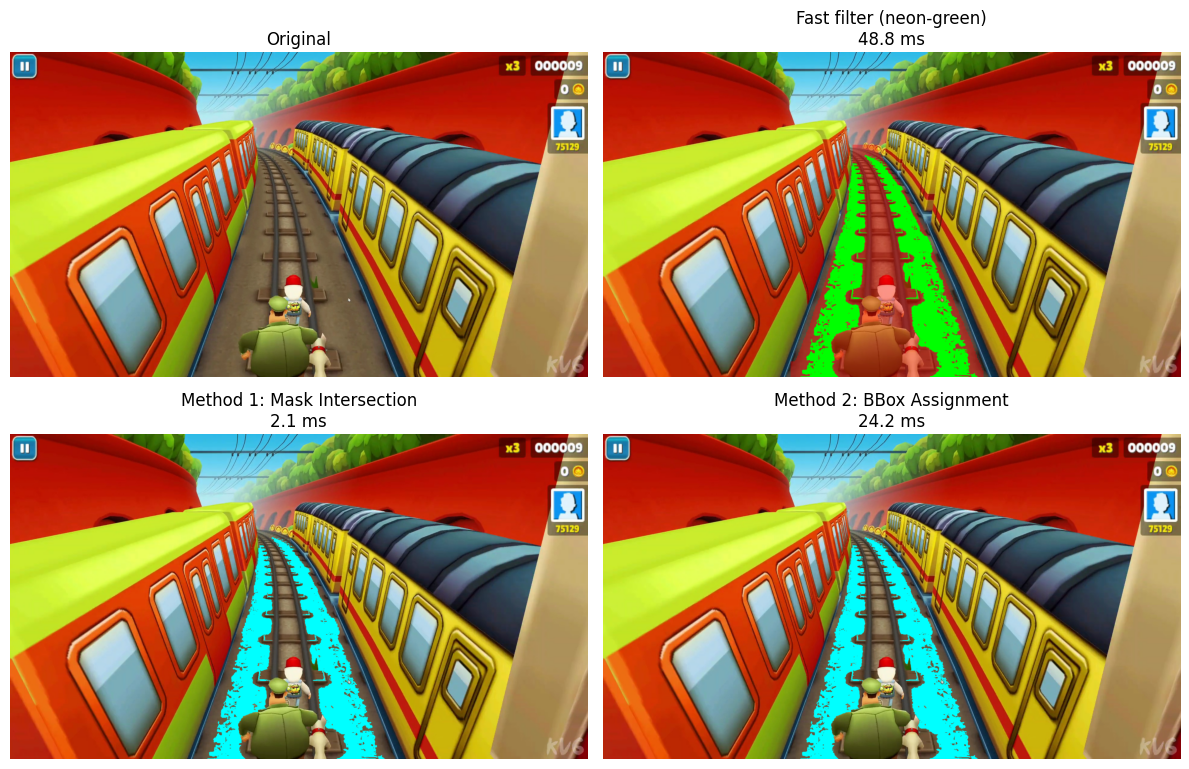

In [7]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint on rail mask

# Color/size filter (RGB targets; converted to BGR internally)
TARGET_COLORS_RGB = [(119, 104, 67), (81, 42, 45)]
TOLERANCE         = 20.0      # color distance (BGR) – increase if too strict
MIN_REGION_SIZE   = 30        # connected-component area in px
MIN_REGION_HEIGHT = 150       # connected-component bbox height in px

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Model (load, fuse, warmup)
# =======================
model = YOLO(weights)
try:
    model.fuse()
except Exception:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# FAST color+size filter
# =======================
def highlight_rails_mask_only_fast(
    img_bgr: np.ndarray,
    rail_mask: np.ndarray,
    target_colors_rgb: list[tuple[int,int,int]],
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 150
) -> np.ndarray:
    """
    Returns boolean mask of rail pixels that:
      (1) color-match any target color within tolerance, AND
      (2) lie inside rail_mask, AND
      (3) pass connected-component size/height filters.
    Vectorized color distance + restrict work to the rail ROI for speed.
    """
    H, W = img_bgr.shape[:2]
    filtered_full = np.zeros((H, W), dtype=bool)

    # Early exit
    if not rail_mask.any():
        return filtered_full

    # Crop to ROI
    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    # Vectorized color match
    targets_bgr = np.array([(c[2], c[1], c[0]) for c in target_colors_rgb],
                           dtype=np.float32)  # (K,3)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:, :, None, :] - targets_bgr[None, None, :, :]
    dist2 = np.sum(diff * diff, axis=-1)
    color_mask_roi = np.any(dist2 <= (tolerance * tolerance), axis=-1)

    combined_roi = mask_roi & color_mask_roi

    # Connected-component filtering in ROI
    comp_u8 = combined_roi.astype(np.uint8)
    n_labels, labels, stats, _ = cv2.connectedComponentsWithStats(comp_u8, 8)

    filtered_roi = np.zeros_like(combined_roi)
    for lbl in range(1, n_labels):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filtered_roi[labels == lbl] = True

    filtered_full[y0:y1, x0:x1] = filtered_roi
    return filtered_full

# =======================
# Method 1: Mask-Intersection
# =======================
def lane_mask_intersection(rail_mask: np.ndarray, obstacle_mask: np.ndarray) -> np.ndarray:
    """
    Split the frame into 3 vertical lanes; for each lane, shade any pixel
    that is both in rail_mask and in obstacle_mask.
    """
    H, W = rail_mask.shape
    thirds = [(0, W//3), (W//3, 2*W//3), (2*W//3, W)]
    out = np.zeros_like(rail_mask)
    for x0, x1 in thirds:
        band = np.zeros_like(rail_mask)
        band[:, x0:x1] = True
        out |= (rail_mask & band & obstacle_mask)
    return out

# =======================
# Method 2: BBox-Assignment
# =======================
def lane_bbox_assignment(rail_mask: np.ndarray, obstacle_mask: np.ndarray) -> np.ndarray:
    """
    Find connected-components in obstacle_mask, assign each component to the
    nearest of three equal-width lanes by its centroid, then shade it.
    """
    H, W = rail_mask.shape
    comp_u8 = obstacle_mask.astype(np.uint8)
    n_lbl, labels, stats, centroids = cv2.connectedComponentsWithStats(comp_u8, 8)
    centers_x = [W/6, W/2, 5*W/6]
    out = np.zeros_like(rail_mask)
    for lbl in range(1, n_lbl):
        cx, _ = centroids[lbl]
        lane_idx = int(np.argmin([abs(cx - c) for c in centers_x]))
        out[(labels == lbl) & rail_mask] = True
    return out

# =======================
# Main: run & compare
# =======================
if __name__ == "__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir, "frame_*.jpg")))
    if not paths:
        print("No frames found in", image_dir)
        sys.exit(1)

    # Process the first frame as a demo
    img_bgr = cv2.imread(paths[0])
    if img_bgr is None:
        print("Failed to read", paths[0])
        sys.exit(1)
    H, W = img_bgr.shape[:2]

    # 1) Rail segmentation
    res = model.predict(
        img_bgr, task="segment", imgsz=IMG_SIZE,
        device=device, conf=CONF, iou=IOU,
        classes=[RAIL_ID], max_det=20,
        verbose=False, half=half
    )[0]
    if res.masks is None:
        rail_mask = np.zeros((H, W), bool)
    else:
        union = (res.masks.data.sum(dim=0) > 0).float().cpu().numpy()
        union = cv2.resize(union, (W, H), interpolation=cv2.INTER_NEAREST)
        rail_mask = union.astype(bool)

    # 2) Fast paint filter
    t0 = time.time()
    paint_mask = highlight_rails_mask_only_fast(
        img_bgr, rail_mask,
        target_colors_rgb=TARGET_COLORS_RGB,
        tolerance=TOLERANCE,
        min_region_size=MIN_REGION_SIZE,
        min_region_height=MIN_REGION_HEIGHT
    )
    t_fast = (time.time() - t0) * 1000  # ms

    out_fast = img_bgr.copy()
    overlay = out_fast.copy()
    overlay[rail_mask] = (0, 0, 255)
    out_fast = cv2.addWeighted(overlay, ALPHA, out_fast, 1 - ALPHA, 0)
    out_fast[paint_mask] = (0, 255, 0)

    # 3) Method 1: Mask-Intersection
    t0 = time.time()
    m1 = lane_mask_intersection(rail_mask, paint_mask)
    t_m1 = (time.time() - t0) * 1000  # ms

    # 4) Method 2: BBox-Assignment
    t0 = time.time()
    m2 = lane_bbox_assignment(rail_mask, paint_mask)
    t_m2 = (time.time() - t0) * 1000  # ms

    # 5) Plot 2×2
    aqua_bgr = np.array([255, 255, 0], dtype=np.uint8)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs = axs.ravel()

    # Top-left: Original
    axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original")
    axs[0].axis("off")

    # Top-right: Fast filter
    axs[1].imshow(cv2.cvtColor(out_fast, cv2.COLOR_BGR2RGB))
    axs[1].set_title(f"Fast filter (neon-green)\n{t_fast:.1f} ms")
    axs[1].axis("off")

    # Bottom-left: Mask-Intersection
    ov1 = img_bgr.copy()
    ov1[m1] = aqua_bgr
    axs[2].imshow(cv2.cvtColor(ov1, cv2.COLOR_BGR2RGB))
    axs[2].set_title(f"Method 1: Mask Intersection\n{t_m1:.1f} ms")
    axs[2].axis("off")

    # Bottom-right: BBox-Assignment
    ov2 = img_bgr.copy()
    ov2[m2] = aqua_bgr
    axs[3].imshow(cv2.cvtColor(ov2, cv2.COLOR_BGR2RGB))
    axs[3].set_title(f"Method 2: BBox Assignment\n{t_m2:.1f} ms")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


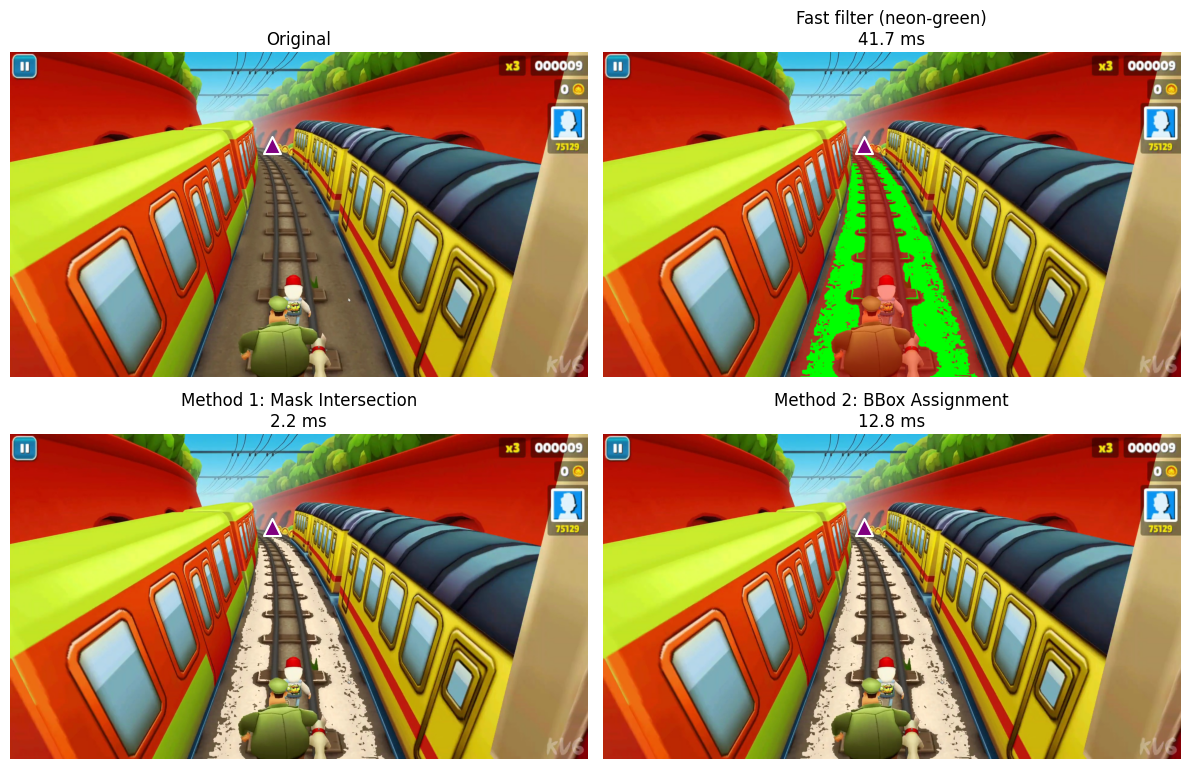

In [9]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint on rail mask

# Color/size filter (RGB targets; converted to BGR internally)
TARGET_COLORS_RGB = [(119, 104, 67), (81, 42, 45)]
TOLERANCE         = 20.0
MIN_REGION_SIZE   = 30
MIN_REGION_HEIGHT = 150

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Load & warm up model
# =======================
model = YOLO(weights)
try:
    model.fuse()
except Exception:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# FAST color+size filter
# =======================
def highlight_rails_mask_only_fast(
    img_bgr: np.ndarray,
    rail_mask: np.ndarray,
    target_colors_rgb: list[tuple[int,int,int]],
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 150
) -> np.ndarray:
    H, W = img_bgr.shape[:2]
    filtered_full = np.zeros((H, W), dtype=bool)
    if not rail_mask.any():
        return filtered_full

    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    targets_bgr = np.array([(c[2], c[1], c[0]) for c in target_colors_rgb], dtype=np.float32)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:, :, None, :] - targets_bgr[None, None, :, :]
    dist2 = np.sum(diff * diff, axis=-1)
    color_mask_roi = np.any(dist2 <= (tolerance * tolerance), axis=-1)

    combined_roi = mask_roi & color_mask_roi

    comp_u8 = combined_roi.astype(np.uint8)
    n_lbl, labels, stats, _ = cv2.connectedComponentsWithStats(comp_u8, 8)
    filtered_roi = np.zeros_like(combined_roi)
    for lbl in range(1, n_lbl):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filtered_roi[labels == lbl] = True

    filtered_full[y0:y1, x0:x1] = filtered_roi
    return filtered_full

# =======================
# Method 1: Mask-Intersection
# =======================
def lane_mask_intersection(rail_mask: np.ndarray, obstacle_mask: np.ndarray) -> np.ndarray:
    H, W = rail_mask.shape
    thirds = [(0, W//3), (W//3, 2*W//3), (2*W//3, W)]
    out = np.zeros_like(rail_mask)
    for x0, x1 in thirds:
        band = np.zeros_like(rail_mask)
        band[:, x0:x1] = True
        out |= (rail_mask & band & obstacle_mask)
    return out

# =======================
# Method 2: BBox-Assignment
# =======================
def lane_bbox_assignment(rail_mask: np.ndarray, obstacle_mask: np.ndarray) -> np.ndarray:
    H, W = rail_mask.shape
    comp_u8 = obstacle_mask.astype(np.uint8)
    n_lbl, labels, stats, centroids = cv2.connectedComponentsWithStats(comp_u8, 8)
    centers_x = [W/6, W/2, 5*W/6]
    out = np.zeros_like(rail_mask)
    for lbl in range(1, n_lbl):
        cx, _ = centroids[lbl]
        lane_idx = int(np.argmin([abs(cx - c) for c in centers_x]))
        out[(labels == lbl) & rail_mask] = True
    return out

# =======================
# Main: run & visualize
# =======================
if __name__ == "__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir, "frame_*.jpg")))
    if not paths:
        print("No frames found in", image_dir)
        sys.exit(1)

    # load a frame
    img_bgr = cv2.imread(paths[0])
    if img_bgr is None:
        print("Failed to read", paths[0])
        sys.exit(1)
    H, W = img_bgr.shape[:2]

    # 1) rail segmentation
    res = model.predict(
        img_bgr, task="segment", imgsz=IMG_SIZE,
        device=device, conf=CONF, iou=IOU,
        classes=[RAIL_ID], max_det=20,
        verbose=False, half=half
    )[0]
    if res.masks is None:
        rail_mask = np.zeros((H, W), bool)
    else:
        union = (res.masks.data.sum(dim=0) > 0).float().cpu().numpy()
        union = cv2.resize(union, (W, H), interpolation=cv2.INTER_NEAREST)
        rail_mask = union.astype(bool)

    # 2) fast paint filter
    t0 = time.time()
    paint_mask = highlight_rails_mask_only_fast(
        img_bgr, rail_mask,
        target_colors_rgb=TARGET_COLORS_RGB,
        tolerance=TOLERANCE,
        min_region_size=MIN_REGION_SIZE,
        min_region_height=MIN_REGION_HEIGHT
    )
    t_fast = (time.time() - t0) * 1000

    out_fast = img_bgr.copy()
    ov = out_fast.copy(); ov[rail_mask] = (0,0,255)
    out_fast = cv2.addWeighted(ov, ALPHA, out_fast, 1-ALPHA, 0)
    out_fast[paint_mask] = (0,255,0)

    # 3) method 1 & 4) method 2
    t0 = time.time(); m1 = lane_mask_intersection(rail_mask, paint_mask)
    t_m1 = (time.time() - t0) * 1000
    t0 = time.time(); m2 = lane_bbox_assignment(rail_mask, paint_mask)
    t_m2 = (time.time() - t0) * 1000

    # 5) detect rails & find their ends
    comp_u8 = rail_mask.astype(np.uint8)
    n_lbl, labels = cv2.connectedComponents(comp_u8, 8)
    rail_ends = []
    for lbl in range(1, n_lbl):
        comp_mask = (labels == lbl)
        ys, xs = np.where(comp_mask)
        if ys.size == 0:
            continue
        y_end = int(ys.min())
        # check if this rail is clear at its end row
        xs_at_end = xs[ys == y_end]
        if xs_at_end.size == 0:
            continue
        # build a 1-pixel-high ROI at y_end
        roi = np.zeros_like(comp_mask)
        roi[y_end, xs_at_end] = True
        # if no obstacle paint there → valid rail
        if not (roi & paint_mask).any():
            x_end = int(xs_at_end.mean())
            rail_ends.append((x_end, y_end))

    # 6) plot 2×2 and overlay purple triangles
    aqua_bgr = np.array([255,255,0], dtype=np.uint8)
    fig, axs = plt.subplots(2,2, figsize=(12,8))
    axs = axs.ravel()

    titles = [
        "Original",
        f"Fast filter (neon-green)\n{t_fast:.1f} ms",
        f"Method 1: Mask Intersection\n{t_m1:.1f} ms",
        f"Method 2: BBox Assignment\n{t_m2:.1f} ms",
    ]
    images = [
        img_bgr,
        out_fast,
        cv2.addWeighted(img_bgr,1,np.dstack([m1]*3).astype(np.uint8)*255,0.5,0),
        cv2.addWeighted(img_bgr,1,np.dstack([m2]*3).astype(np.uint8)*255,0.5,0),
    ]

    for ax, title, img in zip(axs, titles, images):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis("off")
        # draw purple triangles at each valid rail end
        for x_end, y_end in rail_ends:
            ax.scatter(
                x_end, y_end,
                marker='^',
                c='purple',
                s=150,
                edgecolors='white',
                linewidths=1.5
            )

    plt.tight_layout()
    plt.show()


In [ ]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint intensity

TARGET_COLORS_RGB = [(119, 104, 67), (81, 42, 45)]
TOLERANCE         = 20.0
MIN_REGION_SIZE   = 30
MIN_REGION_HEIGHT = 150

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Load & warm up YOLO
# =======================
model = YOLO(weights)
try:
    model.fuse()
except Exception:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# 1) FAST color+size paint filter
# =======================
def highlight_rails_mask_only_fast(
    img_bgr: np.ndarray,
    rail_mask: np.ndarray,
    target_colors_rgb: list[tuple[int,int,int]],
    tolerance: float = 30.0,
    min_region_size: int = 50,
    min_region_height: int = 150
) -> np.ndarray:
    H, W = img_bgr.shape[:2]
    out_mask = np.zeros((H, W), dtype=bool)
    if not rail_mask.any():
        return out_mask

    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1

    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    targets_bgr = np.array([(c[2], c[1], c[0]) for c in target_colors_rgb], dtype=np.float32)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:, :, None, :] - targets_bgr[None, None, :, :]
    dist2 = np.sum(diff * diff, axis=-1)
    color_mask = np.any(dist2 <= tolerance*tolerance, axis=-1)

    combined = mask_roi & color_mask
    cc_u8 = combined.astype(np.uint8)
    n_lbl, labels, stats, _ = cv2.connectedComponentsWithStats(cc_u8, 8)

    filt_roi = np.zeros_like(combined)
    for lbl in range(1, n_lbl):
        area   = stats[lbl, cv2.CC_STAT_AREA]
        height = stats[lbl, cv2.CC_STAT_HEIGHT]
        if area >= min_region_size and height >= min_region_height:
            filt_roi[labels == lbl] = True

    out_mask[y0:y1, x0:x1] = filt_roi
    return out_mask

# =======================
# 2) Mask-Intersection per-lane
# =======================
def lane_mask_intersection(rail_mask: np.ndarray, obs_mask: np.ndarray) -> np.ndarray:
    H, W = rail_mask.shape
    thirds = [(0, W//3), (W//3, 2*W//3), (2*W//3, W)]
    out = np.zeros_like(rail_mask)
    for x0, x1 in thirds:
        band = np.zeros_like(rail_mask)
        band[:, x0:x1] = True
        out |= (rail_mask & band & obs_mask)
    return out

# =======================
# 3) BBox-Assignment per-lane
# =======================
def lane_bbox_assignment(rail_mask: np.ndarray, obs_mask: np.ndarray) -> np.ndarray:
    H, W = rail_mask.shape
    comp = obs_mask.astype(np.uint8)
    n_lbl, labels, stats, centroids = cv2.connectedComponentsWithStats(comp, 8)
    centers_x = [W/6, W/2, 5*W/6]
    out = np.zeros_like(rail_mask)
    for lbl in range(1, n_lbl):
        cx, _ = centroids[lbl]
        lane_idx = int(np.argmin([abs(cx - c) for c in centers_x]))
        out[(labels == lbl) & rail_mask] = True
    return out

# =======================
# helper: draw purple ▲ at each (x,y)
# =======================
def draw_triangles(img: np.ndarray, points: list[tuple[int,int]], size: int = 12):
    for x, y in points:
        pts = np.array([
            [x,           y],
            [x - size, y + size],
            [x + size, y + size],
        ], np.int32)
        cv2.fillPoly(img, [pts], color=(255, 0, 255))          # purple fill
        cv2.polylines(img, [pts], True, color=(255,255,255), thickness=1)

# =======================
# Main loop: show external window, SPACE→next, q→quit
# =======================
if __name__ == "__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir, "frame_*.jpg")))
    if not paths:
        print("No frames found in", image_dir)
        sys.exit(1)

    for path in paths:
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            continue
        H, W = img_bgr.shape[:2]

        # — Rail segmentation —
        res = model.predict(
            img_bgr, task="segment", imgsz=IMG_SIZE,
            device=device, conf=CONF, iou=IOU,
            classes=[RAIL_ID], max_det=20,
            verbose=False, half=half
        )[0]
        if res.masks is None:
            rail_mask = np.zeros((H, W), bool)
        else:
            union = (res.masks.data.sum(dim=0) > 0).float().cpu().numpy()
            union = cv2.resize(union, (W, H), interpolation=cv2.INTER_NEAREST)
            rail_mask = union.astype(bool)

        # — Fast paint filter —
        paint_mask = highlight_rails_mask_only_fast(
            img_bgr, rail_mask,
            target_colors_rgb=TARGET_COLORS_RGB,
            tolerance=TOLERANCE,
            min_region_size=MIN_REGION_SIZE,
            min_region_height=MIN_REGION_HEIGHT
        )
        # compose out_fast
        out_fast = img_bgr.copy()
        ov = out_fast.copy(); ov[rail_mask] = (0,0,255)
        out_fast = cv2.addWeighted(ov, ALPHA, out_fast, 1-ALPHA, 0)
        out_fast[paint_mask] = (0,255,0)

        # — Methods 1 & 2 —
        m1 = lane_mask_intersection(rail_mask, paint_mask)
        m2 = lane_bbox_assignment(rail_mask, paint_mask)

        # — Find dynamic rails & their ends —
        comp_u8 = rail_mask.astype(np.uint8)
        n_lbl, labels = cv2.connectedComponents(comp_u8, 8)
        rail_ends = []
        for lbl in range(1, n_lbl):
            mask_lbl = (labels == lbl)
            ys, xs = np.where(mask_lbl)
            if ys.size == 0:
                continue
            y_end = int(ys.min())
            xs_at_end = xs[ys == y_end]
            if xs_at_end.size == 0:
                continue
            # check 1px ROI at end
            roi = np.zeros_like(mask_lbl)
            roi[y_end, xs_at_end] = True
            if not (roi & paint_mask).any():  # if clear
                x_end = int(xs_at_end.mean())
                rail_ends.append((x_end, y_end))

        # — Build 2×2 mosaic —
        aqua = (255,255,0)
        orig_vis = img_bgr.copy()
        vis_m1 = img_bgr.copy(); vis_m1[m1] = aqua
        vis_m2 = img_bgr.copy(); vis_m2[m2] = aqua

        # draw triangles on each quadrant
        for vis in (orig_vis, out_fast, vis_m1, vis_m2):
            draw_triangles(vis, rail_ends)

        top    = np.hstack([orig_vis, out_fast])
        bottom = np.hstack([vis_m1, vis_m2])
        mosaic = np.vstack([top, bottom])

        # show and wait
        cv2.namedWindow("Rail Comparison", cv2.WINDOW_NORMAL)
        cv2.imshow("Rail Comparison", mosaic)

        while True:
            key = cv2.waitKey(0) & 0xFF
            if key == 32:       # SPACE → next image
                break
            elif key == ord('q'):
                cv2.destroyAllWindows()
                sys.exit(0)

        cv2.destroyWindow("Rail Comparison")


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-04 23:17:40.212 Python[31700:28649964] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-04 23:17:40.212 Python[31700:28649964] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [1]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint on rail mask

TARGET_COLORS_RGB = [(119, 104, 67), (81, 42, 45)]
TOLERANCE         = 20.0
MIN_REGION_SIZE   = 30
MIN_REGION_HEIGHT = 150
MIN_LANE_WIDTH    = 200  # px
MAX_LANES         = 3

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Load & warm up YOLO
# =======================
model = YOLO(weights)
try:
    model.fuse()
except Exception:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# FAST color+size paint filter
# =======================
def highlight_rails_mask_only_fast(
    img_bgr, rail_mask,
    target_colors_rgb, tolerance, min_region_size, min_region_height
):
    H, W = img_bgr.shape[:2]
    out_mask = np.zeros((H, W), dtype=bool)
    if not rail_mask.any():
        return out_mask

    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max()+1
    x0, x1 = xs.min(), xs.max()+1

    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    targets_bgr = np.array([(c[2],c[1],c[0]) for c in target_colors_rgb],dtype=np.float32)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:,:,None,:] - targets_bgr[None,None,:,:]
    dist2 = np.sum(diff*diff,axis=-1)
    color_mask = np.any(dist2 <= tolerance*tolerance,axis=-1)

    combined = mask_roi & color_mask
    cc_u8    = combined.astype(np.uint8)
    n_lbl, labels, stats, _ = cv2.connectedComponentsWithStats(cc_u8,8)

    filt_roi = np.zeros_like(combined)
    for lbl in range(1,n_lbl):
        area   = stats[lbl,cv2.CC_STAT_AREA]
        height = stats[lbl,cv2.CC_STAT_HEIGHT]
        if area>=min_region_size and height>=min_region_height:
            filt_roi[labels==lbl] = True

    out_mask[y0:y1, x0:x1] = filt_roi
    return out_mask

# =======================
# Methods for comparison
# =======================
def lane_mask_intersection(rail_mask, obs_mask):
    H,W = rail_mask.shape
    thirds = [(0,W//3),(W//3,2*W//3),(2*W//3,W)]
    out = np.zeros_like(rail_mask)
    for x0,x1 in thirds:
        band = np.zeros_like(rail_mask); band[:,x0:x1]=True
        out |= (rail_mask & band & obs_mask)
    return out

def lane_bbox_assignment(rail_mask, obs_mask):
    H,W = rail_mask.shape
    comp = obs_mask.astype(np.uint8)
    n_lbl, labels, stats, cents = cv2.connectedComponentsWithStats(comp,8)
    centers_x = [W/6,W/2,5*W/6]
    out = np.zeros_like(rail_mask)
    for lbl in range(1,n_lbl):
        cx,_ = cents[lbl]
        idx  = int(np.argmin([abs(cx-c) for c in centers_x]))
        out[(labels==lbl)&rail_mask] = True
    return out

# =======================
# Draw purple triangle
# =======================
def draw_triangle(img, pt, size=12):
    x,y = pt
    pts = np.array([[x,y],[x-size,y+size],[x+size,y+size]],np.int32)
    cv2.fillPoly(img,[pts],(255,0,255))
    cv2.polylines(img,[pts],True,(255,255,255),1)

# =======================
# Main loop
# =======================
if __name__=="__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir,"frame_*.jpg")))
    if not paths:
        print("No frames found")
        sys.exit(1)

    for p in paths:
        img = cv2.imread(p)
        if img is None: continue
        H,W = img.shape[:2]

        # 1) segment rails
        res = model.predict(
            img, task="segment", imgsz=IMG_SIZE,
            device=device, conf=CONF, iou=IOU,
            classes=[RAIL_ID], max_det=20,
            verbose=False, half=half
        )[0]
        if res.masks is None:
            rail_mask = np.zeros((H,W),bool)
        else:
            u = (res.masks.data.sum(0)>0).float().cpu().numpy()
            rail_mask = cv2.resize(u,(W,H),interpolation=cv2.INTER_NEAREST).astype(bool)

        # 2) paint filter
        paint = highlight_rails_mask_only_fast(
            img, rail_mask,
            TARGET_COLORS_RGB, TOLERANCE,
            MIN_REGION_SIZE, MIN_REGION_HEIGHT
        )

        # 3) comparison methods
        m1 = lane_mask_intersection(rail_mask,paint)
        m2 = lane_bbox_assignment(rail_mask,paint)

        # 4) find top-N rail components by area, width>=MIN_LANE_WIDTH
        comp_u8 = rail_mask.astype(np.uint8)
        n_lbl, labels, stats, _ = cv2.connectedComponentsWithStats(comp_u8,8)
        areas = []
        for lbl in range(1,n_lbl):
            w = stats[lbl,cv2.CC_STAT_WIDTH]
            if w<MIN_LANE_WIDTH: continue
            areas.append((stats[lbl,cv2.CC_STAT_AREA],lbl))
        areas.sort(reverse=True)
        top_lbls = [lbl for _,lbl in areas[:MAX_LANES]]

        # 5) simulate triangle shot down each lane
        collisions = []
        for lbl in top_lbls:
            left = stats[lbl,cv2.CC_STAT_LEFT]
            width= stats[lbl,cv2.CC_STAT_WIDTH]
            cx = left + width//2

            ys = np.where(labels==lbl)[0]
            y_max = ys.max()
            y_min = ys.min()

            # move upward until paint obstacle hit
            y_hit = y_min
            for y in range(y_max, y_min-1, -1):
                if paint[y, cx]:
                    y_hit = y+1
                    break
            collisions.append((cx, y_hit))

        # 6) build 2×2 mosaic & draw
        red = (0,0,255); green = (0,255,0); aqua=(255,255,0)
        out_fast = img.copy(); ov=out_fast.copy()
        ov[rail_mask]=red
        out_fast = cv2.addWeighted(ov,ALPHA,out_fast,1-ALPHA,0)
        out_fast[paint]=green

        vis_m1 = img.copy(); vis_m1[m1]=aqua
        vis_m2 = img.copy(); vis_m2[m2]=aqua

        quads = [img,out_fast,vis_m1,vis_m2]
        for vis in quads:
            for pt in collisions:
                draw_triangle(vis, pt)

        top    = np.hstack(quads[:2])
        bottom = np.hstack(quads[2:])
        canvas = np.vstack([top,bottom])

        cv2.namedWindow("Rails",cv2.WINDOW_NORMAL)
        cv2.imshow("Rails",canvas)
        key = cv2.waitKey(0)&0xFF
        if key==ord('q'):
            break
        # SPACE or anything else → next
        cv2.destroyWindow("Rails")

    cv2.destroyAllWindows()


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-04 23:33:28.627 Python[32875:28681236] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-04 23:33:28.628 Python[32875:28681236] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [ ]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
from ultralytics import YOLO
from skimage.morphology import skeletonize

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint on rail mask

# Color/size filter (RGB targets; converted to BGR internally)
TARGET_COLORS_RGB = [(119,104,67), (81,42,45)]
TOLERANCE         = 20.0      # color distance (BGR)
MIN_REGION_SIZE   = 30        # connected-component area in px
MIN_REGION_HEIGHT = 150       # connected-component bbox height in px

# Skeleton pruning by width
MIN_SKELETON_WIDTH = 60       # minimum lane-width in px to keep a skeleton branch

# =======================
# Device / precision
# =======================
if torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends, "mps", None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

# =======================
# Model (load, fuse, warmup)
# =======================
model = YOLO(weights)
try:
    model.fuse()
except:
    pass

_dummy = np.zeros((IMG_SIZE, IMG_SIZE, 3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE, device=device,
    conf=CONF, iou=IOU, classes=[RAIL_ID],
    verbose=False, half=half
)

# =======================
# FAST color+size filter
# =======================
def highlight_rails_mask_only_fast(
    img_bgr: np.ndarray,
    rail_mask: np.ndarray,
    target_colors_rgb: list[tuple[int,int,int]],
    tolerance: float,
    min_region_size: int,
    min_region_height: int
) -> np.ndarray:
    H, W = img_bgr.shape[:2]
    filtered_full = np.zeros((H, W), dtype=bool)
    if not rail_mask.any():
        return filtered_full

    # ROI crop
    ys, xs = np.where(rail_mask)
    y0, y1 = ys.min(), ys.max() + 1
    x0, x1 = xs.min(), xs.max() + 1
    img_roi  = img_bgr[y0:y1, x0:x1]
    mask_roi = rail_mask[y0:y1, x0:x1]

    # color match
    targets_bgr = np.array([(r,g,b)[::-1] for r,g,b in target_colors_rgb], np.float32)
    img_f = img_roi.astype(np.float32)
    diff  = img_f[:,:,None,:] - targets_bgr[None,None,:,:]
    dist2 = np.sum(diff*diff, axis=-1)
    color_mask = np.any(dist2 <= (tolerance*tolerance), axis=-1)

    combined = mask_roi & color_mask

    # component filter
    comp_u8 = combined.astype(np.uint8)
    n, labels, stats, _ = cv2.connectedComponentsWithStats(comp_u8, 8)
    filt = np.zeros_like(combined)
    for i in range(1,n):
        area   = stats[i,cv2.CC_STAT_AREA]
        height = stats[i,cv2.CC_STAT_HEIGHT]
        if area>=min_region_size and height>=min_region_height:
            filt[labels==i] = True

    filtered_full[y0:y1, x0:x1] = filt
    return filtered_full

# =======================
# Per-frame pipeline
# =======================
def process_frame(img_bgr: np.ndarray):
    """
    Returns:
      - vis: original tinted with rails (red) and filtered (green)
      - rail_mask: bool mask of all rails
      - filtered_mask: bool mask of color+size filtered rail pixels
    """
    res = model.predict(
        img_bgr, task="segment", imgsz=IMG_SIZE, device=device,
        conf=CONF, iou=IOU, classes=[RAIL_ID],
        max_det=20, verbose=False, half=half
    )[0]
    H, W = img_bgr.shape[:2]
    if res.masks is None:
        return img_bgr.copy(), np.zeros((H,W),bool), np.zeros((H,W),bool)

    # union rail masks → resize
    m = res.masks.data
    union = (m.sum(dim=0)>0).float().cpu().numpy()
    if union.shape != (H,W):
        union = cv2.resize(union, (W,H), interpolation=cv2.INTER_NEAREST)
    rail_mask = union.astype(bool)

    # filter inside rail_mask
    filtered_mask = highlight_rails_mask_only_fast(
        img_bgr, rail_mask,
        TARGET_COLORS_RGB,
        TOLERANCE,
        MIN_REGION_SIZE,
        MIN_REGION_HEIGHT
    )

    # compose tinted view
    vis = img_bgr.copy()
    over = vis.copy(); over[rail_mask] = (0,0,255)
    vis = cv2.addWeighted(over, ALPHA, vis, 1-ALPHA, 0)
    vis[filtered_mask] = (0,255,0)

    return vis, rail_mask, filtered_mask

# =======================
# Main: display 3 panels with width-pruned skeleton
# =======================
if __name__=="__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir,"frame_*.jpg")))
    if not paths:
        print("No frames found"); sys.exit(1)

    for p in paths:
        img = cv2.imread(p)
        if img is None:
            continue

        vis, rail_mask, filtered_mask = process_frame(img)
        lane_mask = rail_mask & (~filtered_mask)

        # skeletonize lanes
        sk = skeletonize(lane_mask).astype(np.uint8)

        # compute distance‐transform of lane_mask
        dist = cv2.distanceTransform((lane_mask*255).astype(np.uint8),
                                     cv2.DIST_L2, cv2.DIST_MASK_PRECISE)

        # prune skeleton branches narrower than MIN_SKELETON_WIDTH
        n_s, lbls = cv2.connectedComponents(sk, connectivity=8)
        sk_clean = np.zeros_like(sk)
        for lbl in range(1, n_s):
            comp = (lbls == lbl)
            # measure maximum width along this branch
            # width ≈ 2 * max(distance_transform)
            max_radius = dist[comp].max() if comp.any() else 0
            max_width = 2 * max_radius
            if max_width >= MIN_SKELETON_WIDTH:
                sk_clean[comp] = 1

        # make skeleton overlay
        sk_vis = img.copy()
        sk_vis[sk_clean==1] = (255,255,0)  # BGR aqua

        # top row: original | tinted+filtered
        top = np.hstack((img, vis))

        # bottom: width-pruned skeleton overlay | blank
        blank = np.zeros_like(img)
        bottom = np.hstack((sk_vis, blank))

        canvas = np.vstack((top, bottom))
        cv2.imshow("Orig | Rails+Filt (top)   Skeleton (bottom left)", canvas)

        # advance on SPACE, quit on 'q'
        while True:
            k = cv2.waitKey(0) & 0xFF
            if k == 32:    # space
                break
            if k == ord('q'):
                cv2.destroyAllWindows()
                sys.exit(0)

        cv2.destroyAllWindows()
        time.sleep(0.02)


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-04 23:34:23.407 Python[32933:28682169] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-04 23:34:23.407 Python[32933:28682169] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [1]:
#Wonky tracking but kind of with pink arrows

In [ ]:
#!/usr/bin/env python3
import os, glob, sys, time

import cv2
import torch
import numpy as np
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40

TARGET_COLORS_RGB = [(119,104,67),(81,42,45)]
TOLERANCE         = 20.0
MIN_REGION_SIZE   = 30
MIN_REGION_HEIGHT = 150

# =======================
# Device / warm-up
# =======================
if   torch.cuda.is_available():       device,half=0,True
elif getattr(torch.backends,"mps",None) and torch.backends.mps.is_available(): device,half="mps",False
else:                                 device,half="cpu",False

model = YOLO(weights)
try: model.fuse()
except: pass

_dummy = np.zeros((IMG_SIZE,IMG_SIZE,3),np.uint8)
_ = model.predict(_dummy, task="segment", imgsz=IMG_SIZE,
                  device=device, conf=CONF, iou=IOU,
                  classes=[RAIL_ID], verbose=False, half=half)

# =======================
# Fast color+size paint filter
# =======================
def highlight_rails_mask_only_fast(img, rail_mask,
                                   targets, tol, min_sz, min_h):
    H,W = img.shape[:2]
    out = np.zeros((H,W),bool)
    if not rail_mask.any(): return out

    ys,xs = np.where(rail_mask)
    y0,y1 = ys.min(), ys.max()+1
    x0,x1 = xs.min(), xs.max()+1

    roi = img[y0:y1,x0:x1].astype(np.float32)
    targ = np.array([(c[2],c[1],c[0]) for c in targets],np.float32)
    diff = roi[:,:,None,:] - targ[None,None,:,:]
    dist2= np.sum(diff*diff,axis=-1)
    cmask= np.any(dist2<=tol*tol,axis=-1)

    comb = cmask & rail_mask[y0:y1,x0:x1]
    cc_u8= comb.astype(np.uint8)
    n, labels, stats, _ = cv2.connectedComponentsWithStats(cc_u8,8)

    filt = np.zeros_like(comb)
    for lbl in range(1,n):
        a = stats[lbl,cv2.CC_STAT_AREA]
        h = stats[lbl,cv2.CC_STAT_HEIGHT]
        if a>=min_sz and h>=min_h:
            filt[labels==lbl] = True

    out[y0:y1,x0:x1] = filt
    return out

# =======================
# Per-frame: segment + paint
# =======================
def process_frame(img):
    H,W = img.shape[:2]
    r = model.predict(img, task="segment", imgsz=IMG_SIZE,
                      device=device, conf=CONF, iou=IOU,
                      classes=[RAIL_ID], max_det=20,
                      verbose=False, half=half)[0]
    if r.masks is None:
        return img.copy(), np.zeros((H,W),bool), np.zeros((H,W),bool)

    uni = (r.masks.data.sum(0)>0).float().cpu().numpy()
    rail = cv2.resize(uni,(W,H),interpolation=cv2.INTER_NEAREST).astype(bool)
    paint = highlight_rails_mask_only_fast(
        img, rail,
        TARGET_COLORS_RGB, TOLERANCE,
        MIN_REGION_SIZE, MIN_REGION_HEIGHT
    )

    # tinted + neon-green
    vis = img.copy()
    ov  = vis.copy(); ov[rail] = (0,0,255)
    vis = cv2.addWeighted(ov,ALPHA,vis,1-ALPHA,0)
    vis[paint] = (0,255,0)
    return vis, rail, paint

# =======================
# Fast center-line “skeleton”
# =======================
def fast_centerline_unpainted(rail_mask, paint_mask):
    H,W = rail_mask.shape
    lane = rail_mask & (~paint_mask)
    centers = []
    # for each row y, find x-coords of lane[y], take mean
    for y in range(H):
        xs = np.where(lane[y])[0]
        if xs.size:
            centers.append((int(xs.mean()), y))
    return centers

# =======================
# Draw purple ▲
# =======================
def draw_triangles(img, pts, size=10):
    for x,y in pts:
        tri = np.array([[x,y],[x-size,y+size],[x+size,y+size]],np.int32)
        cv2.fillPoly(img, [tri], (255,0,255))
        cv2.polylines(img,[tri],True,(255,255,255),1)

# =======================
# Main loop
# =======================
if __name__=="__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    files = sorted(glob.glob(os.path.join(image_dir,"frame_*.jpg")))
    if not files:
        print("No frames"); sys.exit(1)

    for path in files:
        img = cv2.imread(path)
        if img is None: continue

        vis, rail, paint = process_frame(img)

        # build each quadrant
        q0 = img.copy()    # original
        q1 = vis           # tinted+paint
        q2 = q0.copy()     # (unused)
        q3 = q0.copy()     # (unused)

        # fast skeleton
        pts = fast_centerline_unpainted(rail, paint)
        for q in (q0,q1,q2,q3):
            draw_triangles(q, pts)

        top    = np.hstack((q0,q1))
        bottom = np.hstack((q2,q3))
        canvas = np.vstack((top,bottom))

        cv2.namedWindow("Rail Preview",cv2.WINDOW_NORMAL)
        cv2.imshow("Rail Preview", canvas)
        key = cv2.waitKey(0) & 0xFF
        if key==ord('q'):
            break
        cv2.destroyWindow("Rail Preview")

    cv2.destroyAllWindows()


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-04 23:39:01.322 Python[33147:28686762] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-04 23:39:01.322 Python[33147:28686762] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


In [2]:
#Imprived logic for pink tris?!

In [ ]:
#!/usr/bin/env python3
import os
import glob
import sys
import time

import cv2
import torch
import numpy as np
from ultralytics import YOLO

# =======================
# Config
# =======================
home     = os.path.expanduser("~")
weights  = f"{home}/models/jakes-loped/jakes-finder-mk1/1/weights.pt"
RAIL_ID  = 9

IMG_SIZE = 512
CONF, IOU = 0.30, 0.45
ALPHA    = 0.40  # red tint opacity

TARGET_COLORS_RGB = [(119,104,67),(81,42,45)]
TOLERANCE         = 20.0
MIN_REGION_SIZE   = 30
MIN_REGION_HEIGHT = 150

# =======================
# Device / Model warm-up
# =======================
if   torch.cuda.is_available():
    device, half = 0, True
elif getattr(torch.backends,"mps",None) and torch.backends.mps.is_available():
    device, half = "mps", False
else:
    device, half = "cpu", False

model = YOLO(weights)
try:
    model.fuse()
except:
    pass

_dummy = np.zeros((IMG_SIZE,IMG_SIZE,3), np.uint8)
_ = model.predict(
    _dummy, task="segment", imgsz=IMG_SIZE,
    device=device, conf=CONF, iou=IOU,
    classes=[RAIL_ID], verbose=False, half=half
)

# =======================
# Fast color+size filter
# =======================
def highlight_rails_mask_only_fast(img, rail_mask,
                                   targets, tol, min_sz, min_h):
    H,W = img.shape[:2]
    out = np.zeros((H,W), bool)
    if not rail_mask.any():
        return out

    ys,xs = np.where(rail_mask)
    y0,y1 = ys.min(), ys.max()+1
    x0,x1 = xs.min(), xs.max()+1

    roi = img[y0:y1, x0:x1].astype(np.float32)
    targ = np.array([(c[2],c[1],c[0]) for c in targets], np.float32)
    diff = roi[:,:,None,:] - targ[None,None,:,:]
    dist2= np.sum(diff*diff, axis=-1)
    cmask= np.any(dist2 <= tol*tol, axis=-1)

    comb = cmask & rail_mask[y0:y1, x0:x1]
    cc_u8 = comb.astype(np.uint8)
    n, labels, stats, _ = cv2.connectedComponentsWithStats(cc_u8, 8)

    filt = np.zeros_like(comb)
    for lbl in range(1,n):
        a = stats[lbl,cv2.CC_STAT_AREA]
        h = stats[lbl,cv2.CC_STAT_HEIGHT]
        if a>=min_sz and h>=min_h:
            filt[labels==lbl] = True

    out[y0:y1, x0:x1] = filt
    return out

# =======================
# Process frame: segment + paint
# =======================
def process_frame(img):
    H,W = img.shape[:2]
    r = model.predict(
        img, task="segment", imgsz=IMG_SIZE,
        device=device, conf=CONF, iou=IOU,
        classes=[RAIL_ID], max_det=20,
        verbose=False, half=half
    )[0]
    if r.masks is None:
        rail = np.zeros((H,W), bool)
    else:
        uni = (r.masks.data.sum(0)>0).float().cpu().numpy()
        rail = cv2.resize(uni, (W,H), interpolation=cv2.INTER_NEAREST).astype(bool)

    paint = highlight_rails_mask_only_fast(
        img, rail,
        TARGET_COLORS_RGB, TOLERANCE,
        MIN_REGION_SIZE, MIN_REGION_HEIGHT
    )

    # tinted + neon-green
    vis = img.copy()
    ov  = vis.copy(); ov[rail] = (0,0,255)
    vis = cv2.addWeighted(ov,ALPHA,vis,1-ALPHA,0)
    vis[paint] = (0,255,0)
    return vis, rail, paint

# =======================
# Compute one center-line per rail component
# =======================
def compute_rail_centerlines(rail_mask, paint_mask):
    """
    For each connected component in rail_mask:
      - restrict to its painted (neon-green) subregion
      - on each row, take the midpoint x of that subregion
      - collect those (x,y) into a polyline
    """
    cc_u8 = rail_mask.astype(np.uint8)
    n, labels, stats, _ = cv2.connectedComponentsWithStats(cc_u8, 8)

    centerlines = []
    for lbl in range(1, n):
        comp = (labels == lbl)
        safe = comp & paint_mask
        if not safe.any():
            continue

        ys = np.where(safe.any(axis=1))[0]
        pts = []
        for y in ys:
            xs = np.where(safe[y])[0]
            if xs.size:
                xm = int(xs.mean())
                pts.append((xm, int(y)))
        if len(pts) > 1:
            centerlines.append(pts)
    return centerlines

# =======================
# Draw pink center-lines
# =======================
def draw_centerlines(img, lines, color=(255,0,255), thickness=2):
    for pts in lines:
        arr = np.array(pts, np.int32)
        cv2.polylines(img, [arr], False, color, thickness, cv2.LINE_AA)

# =======================
# Main loop: SPACE→next, q→quit
# =======================
if __name__=="__main__":
    image_dir = f"{home}/SubwaySurfers/train_screenshots"
    paths = sorted(glob.glob(os.path.join(image_dir,"frame_*.jpg")))
    if not paths:
        print("No frames found"); sys.exit(1)

    for path in paths:
        img = cv2.imread(path)
        if img is None: continue

        vis, rail, paint = process_frame(img)
        centerlines = compute_rail_centerlines(rail, paint)

        # prepare 2×2 view
        q0 = img.copy()    # original
        q1 = vis           # tinted+paint
        q2 = img.copy()    # placeholder
        q3 = img.copy()    # placeholder

        # draw pink lines on each quadrant
        for q in (q0, q1, q2, q3):
            draw_centerlines(q, centerlines)

        top    = np.hstack((q0, q1))
        bottom = np.hstack((q2, q3))
        canvas = np.vstack((top,bottom))

        cv2.namedWindow("Rails & Centerlines", cv2.WINDOW_NORMAL)
        cv2.imshow("Rails & Centerlines", canvas)

        while True:
            key = cv2.waitKey(0) & 0xFF
            if key == 32:   # SPACE → next
                break
            elif key == ord('q'):
                cv2.destroyAllWindows()
                sys.exit(0)

        cv2.destroyWindow("Rails & Centerlines")

    cv2.destroyAllWindows()


YOLO11n-seg summary (fused): 113 layers, 2,836,908 parameters, 0 gradients, 10.2 GFLOPs


2025-08-04 23:44:36.886 Python[33724:28697702] +[IMKClient subclass]: chose IMKClient_Legacy
2025-08-04 23:44:36.886 Python[33724:28697702] +[IMKInputSession subclass]: chose IMKInputSession_Legacy
